# Data Science Hands-on

**Second day**     

The goal of this notebook is:
- Explore different ML algorithms
- Check the performance of different ML algorithms
- Look at what features are more important to predict the target 

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Scikit_learn_logo_small.svg/1200px-Scikit_learn_logo_small.svg.png" width="20%" />

In [1]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

import scipy.stats

from handson import get_scores, plot_predict_result
# %matplotlib notebook
%matplotlib inline
pd.options.display.max_columns = None

In [2]:
df = pd.read_csv('../data/dataset_ready.csv')

features = df.drop(columns='precio')
price = df['precio']

In [3]:
from scipy import stats


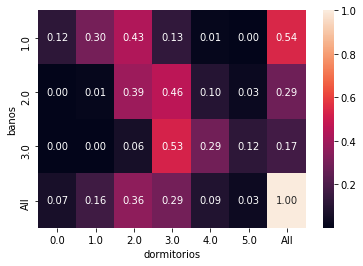

In [4]:
cr_df = pd.crosstab(df['banos'], df['dormitorios'], margins=True)
cr_ndf = cr_df.copy()
cr_df.iloc[:-1, :-1] = cr_df.iloc[:-1, :-1].apply(lambda x: x/cr_df.iloc[:-1, -1])
cr_df.iloc[:-1, -1] /= cr_df.iloc[-1, -1]
cr_df.iloc[-1, :-1] /= cr_df.iloc[-1, -1]
cr_df.iloc[-1, -1] = 1
sns.heatmap(cr_df, annot=True, fmt='0.2f')

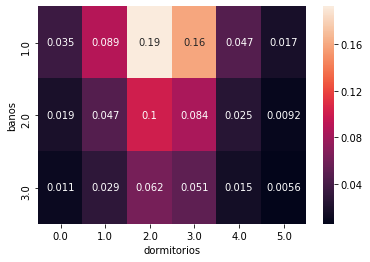

In [5]:
expected = pd.DataFrame(
    data=cr_df.iloc[-1, :-1].to_numpy()[:] * cr_df.iloc[:-1, -1].to_numpy()[:, None],
    index=cr_df.index[:-1],
    columns=cr_df.columns[:-1])
sns.heatmap(expected, annot=True)

In [6]:
((cr_df.iloc[:-1, :-1] - expected)**2/expected).sum().sum()

15.689858400455504

In [7]:
stats.chi2_contingency(cr_ndf.iloc[:-1, :-1].to_numpy())[:3]

(11164.422991237225, 0.0, 10)

# Learning algorithms
“A computer program is said to learn from experience **E** with respect to some task **T** and some performance measure **P**, if its performance on **T**, as measured by **P**, improves with experience **E**.” -- Tom Mitchell, Carnegie Mellon University



# Modeling
 $X = [x1, x2, x3, ...]$ are the independent variables $y$ is the target variable

## Split train and test dataset
How well is my model doing?
We make a **i.i.d** assumptions, it's mean that our examples are independent from each other, and the teining and test sample are  identically distributed.
<img src="https://miro.medium.com/max/700/1*-8_kogvwmL1H6ooN1A1tsQ.png" width="50%"/>

In [8]:
X_train, X_test = train_test_split(features, test_size=0.2, random_state=0)
y_train, y_test = train_test_split(price, test_size=0.2, random_state=0)

## Check train and test distributions

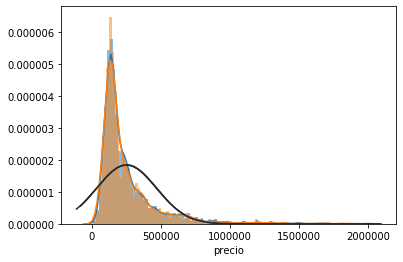

In [9]:
f, ax = plt.subplots(1)
sns.distplot(y_train, bins=100, hist_kws={'alpha':0.5}, fit=scipy.stats.norm, ax=ax);
sns.distplot(y_test, bins=100, hist_kws={'alpha':0.5}, fit=scipy.stats.norm, ax=ax);

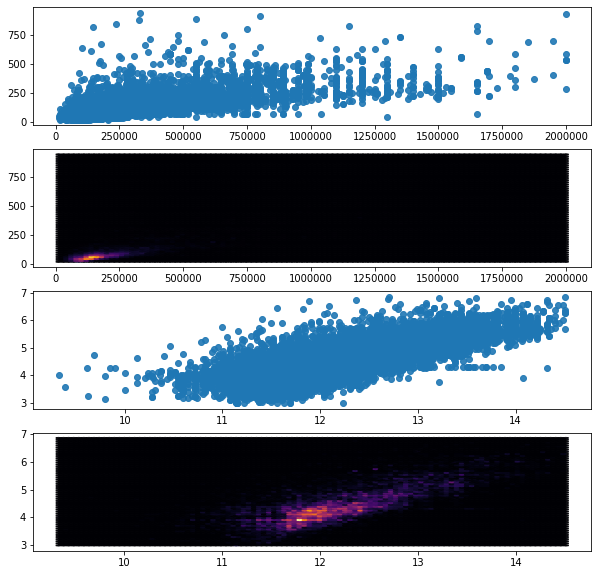

In [10]:
f, ax = plt.subplots(4, figsize=(10, 10))
ax[0].scatter(y_train, X_train['m2_edificados'], alpha=0.9)
ax[1].hexbin(y_train, X_train['m2_edificados'], alpha=0.9, gridsize=100, cmap='inferno')
ax[2].scatter(np.log(y_train), np.log(X_train['m2_edificados']), alpha=0.9)
ax[3].hexbin(np.log(y_train), np.log(X_train['m2_edificados']), alpha=0.9, gridsize=100, cmap='inferno')

## Scale dataset

In [11]:
scaler_target = QuantileTransformer(output_distribution='normal', ) 
scaler_std = StandardScaler()


In [12]:
X_train_norm = scaler_std.fit_transform(X_train)
X_test_norm = scaler_std.transform(X_test)

y_train_norm = scaler_target.fit_transform(y_train.to_numpy()[:, None])
y_test_norm = scaler_target.transform(y_test.to_numpy()[:, None])

# Unsupervised learning
## Principal Component Analysis
"PCA is a commonly used algorithm in data science to compresses your data from a higher dimension to a lower dimension based on the eigenvector of the variance in your dataset."

PCA finds the directions of maximum variance and projects the data along them to reduce the dimensions.

Without going into the math, these directions are the eigenvectors of the covariance matrix of the data.
<img src="https://miro.medium.com/max/602/1*H38t3YUv_QktLwalzDYRRg.png" width="50%"/>

In [13]:
pca = PCA(n_components=0.95, )
X_train_pca = pca.fit_transform(X_train_norm)
X_test_pca = pca.transform(X_test_norm)
print('X shape: {}, X PCA shape: {}'.format(X_train_norm.shape, X_train_pca.shape))

X shape: (17457, 30), X PCA shape: (17457, 24)


In [14]:
pca.explained_variance_ratio_

array([0.12137526, 0.08605089, 0.06069756, 0.0519722 , 0.04436656,
       0.04041283, 0.03829754, 0.03748008, 0.03659248, 0.03594753,
       0.03504998, 0.03486951, 0.03467483, 0.03432887, 0.03271023,
       0.03135539, 0.03045266, 0.02947385, 0.02623973, 0.02509812,
       0.0243113 , 0.02246277, 0.02093458, 0.01855457])

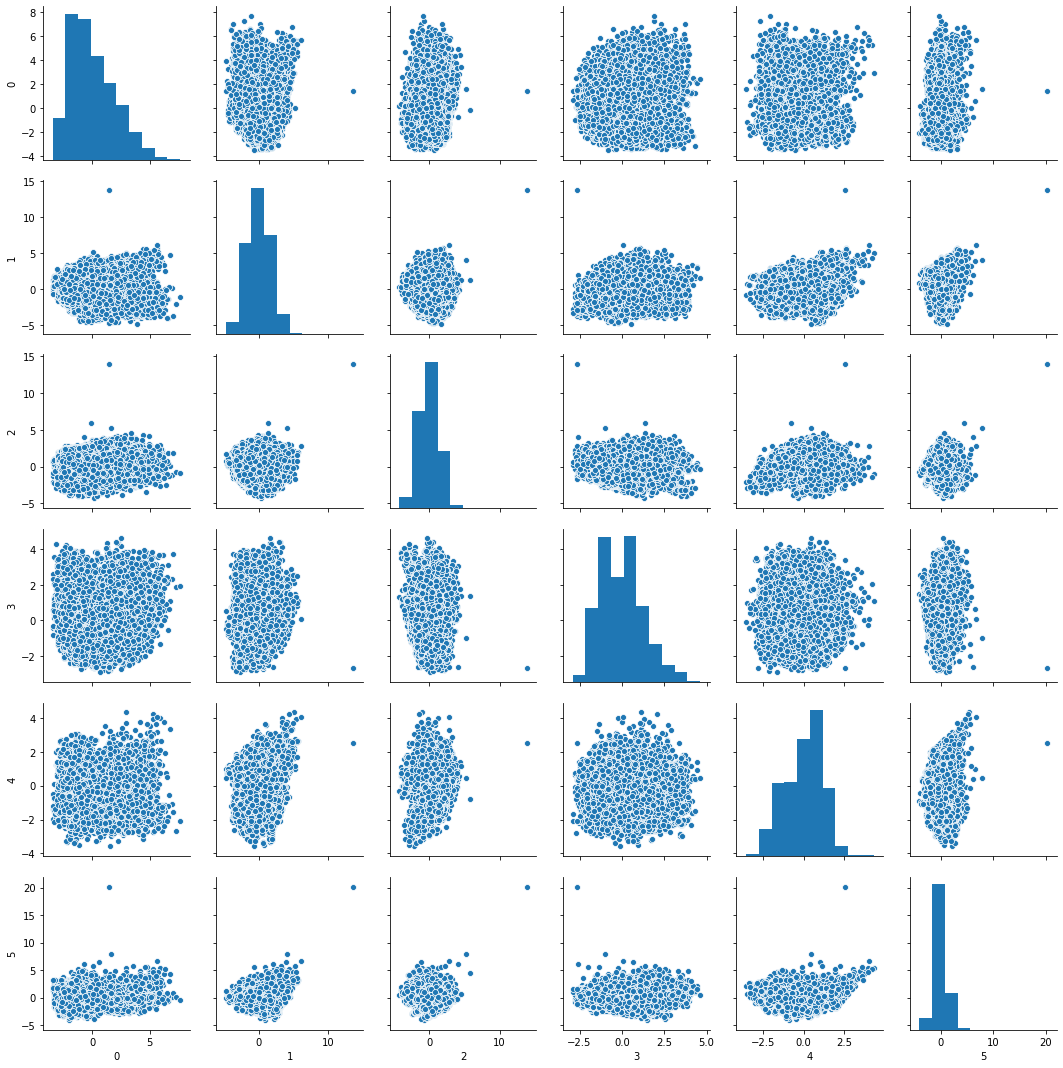

In [15]:
sns.pairplot(pd.DataFrame(X_train_pca[:, 0:6]))

In [16]:
X_train.columns

Index(['index', 'banos', 'dormitorios', 'garajes', 'gastos_comunes',
       'm2_de_la_terraza', 'm2_edificados', 'penthouse', 'plantas',
       'vivienda_social', 'cerca_rambla', 'm2_index', 'es_casa', 'parrilero',
       'decada', 'ZN__carrasco', 'ZN__centro', 'ZN__cordon',
       'ZN__la blanqueada', 'ZN__malvin', 'ZN__otros', 'ZN__parque batlle',
       'ZN__pocitos', 'ZN__punta carretas', 'DISP__', 'DISP__al frente',
       'DISP__contrafrente', 'DISP__interior', 'DISP__lateral', 'estado'],
      dtype='object')

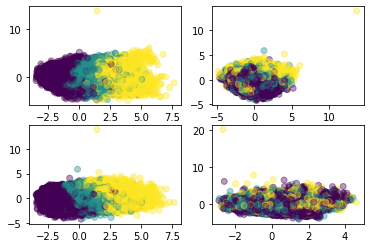

In [17]:
color = X_train.loc[:, 'banos']
f, ax = plt.subplots(2,2)
ax[0, 0].scatter(X_train_pca[:,0], X_train_pca[:,1], c=color, alpha=0.4)
ax[0, 1].scatter(X_train_pca[:,1], X_train_pca[:,2], c=color, alpha=0.4)
ax[1, 0].scatter(X_train_pca[:,0], X_train_pca[:,2], c=color, alpha=0.4)
ax[1, 1].scatter(X_train_pca[:,3], X_train_pca[:,5], c=color, alpha=0.4)


# Choosing a model
<img src="https://byam.github.io/assets/img/model-eval-val/regress-class.png" width=600/>

[ref img](https://byam.github.io/dlnd/2017/11/13/model-evaluation-and-validation.html)

## How to select the right regression model?

- Data exploration is an inevitable part of building predictive model. It should be you first step before selecting the right model like identify the relationship and impact of variables
- To compare the goodness of fit for different models, we can analyse different metrics like statistical significance of parameters, R-square, Adjusted r-square, AIC, BIC and error term. Another one is the Mallow’s Cp criterion. This essentially checks for possible bias in your model, by comparing the model with all possible submodels (or a careful selection of them).
- Cross-validation is the best way to evaluate models used for prediction. Here you divide your data set into two group (train and validate). A simple mean squared difference between the observed and predicted values give you a measure for the prediction accuracy.
- If your data set has multiple confounding variables, you should not choose automatic model selection method because you do not want to put these in a model at the same time.
- It’ll also depend on your objective. It can occur that a less powerful model is easy to implement as compared to a highly statistically significant model.
- Regression regularization methods(Lasso, Ridge and ElasticNet) works well in case of high dimensionality and multicollinearity among the variables in the data set.

reref: https://www.analyticsvidhya.com/blog/2015/08/comprehensive-guide-regression/?utm_source=blog&utm_medium=RideandLassoRegressionarticle

## Regression
Regression analysis is a form of predictive modelling technique which investigates the relationship between a dependent $y$ (target) and independent variable (s) $\mathbf{X}$ (predictor). Some common uses are forecasting, time series modelling and finding the causal effect relationship between the variables.


We have a collection of labeled examples ${(X_i, y_i)}_{i=1}^{N}$

Some types are:
- Linear Regression
- Polynomial Regression
- 

## Evaluation metrics for Regression problems

**Which metric we should choice to evaluate our models?**

### Mean Absolute Error
<img src="https://byam.github.io/assets/img/model-eval-val/mean-absolute-error.png" width=200/>

$$MAE = \frac{\sum_{i=1}^{N}|y_i - \hat{y_i}|}{m}$$

### Mean squared Error
<img src="https://byam.github.io/assets/img/model-eval-val/mean-squared-error.png" width=200/>
$$MSE = \frac{\sum_{i=1}^{N}(y_i - \hat{y_i})^2}{m}$$

### $R^2$
$R^2$ also known as the Coefficient of Determination, is a general evaluation of the model showing the percentage of variation in the prediction that can be explained by the features.
<img src="https://miro.medium.com/max/1400/1*F3l0a4hMQPo_eOmGZMRE-w.png" width=200 />

$$
SS_t = \sum_{i=1}^{N}(y_i - \bar{y})^2\\
SS_e = \sum_{i=1}^{N}(y_i - \hat{y_i})^2\\
R^2 = 1 - \frac{SS_e}{SS_t}
$$
- $SS_e$: Sum of squares error
- $SS_t$: sum of squares total

## Linear Model
Linear model calculates the best-fit line for the observed data by minimizing the sum of the squares of the vertical deviations from each observed point to the line.
### Definition
$$f_{\mathbf{w},b}(x) = \mathbf{w}x+b\\$$
Where $\mathbf{w}$ are the weight of each independent variable and $b$ is the intercept.
$$min(\sum_{i=1}^{N}(y_i-\hat{y_i})^2) = min(\sum_{i=1}^{N}(y_i-\sum_{j=0}^{M}w_j \cdot x_{ij})^2)$$

<img src="http://docs.statwing.com/wp-content/uploads/2014/10/basic-actual-to-standardized.png" width="70%"/>

Important Points:
- There must be linear relationship between **independent and dependent variables**
- Multiple regression suffers from **multicollinearity, autocorrelation, heteroskedasticity.**
- Linear Regression is very **sensitive to Outliers**. It can terribly affect the regression line and eventually the forecasted values.
- **Multicollinearity** can increase the variance of the coefficient estimates and make the estimates very sensitive to minor changes in the model. The result is that the coefficient estimates are unstable
- In case of multiple independent variables, we can go with **forward selection**, **backward elimination** and **step wise** approach for selection of most significant independent variables.

Test: RMSE=1.19, MAE=0.66, MEAE=0.38, $R^2$=0.70
Train: RMSE=1.15, MAE=0.65, MEAE=0.38, $R^2$=0.72


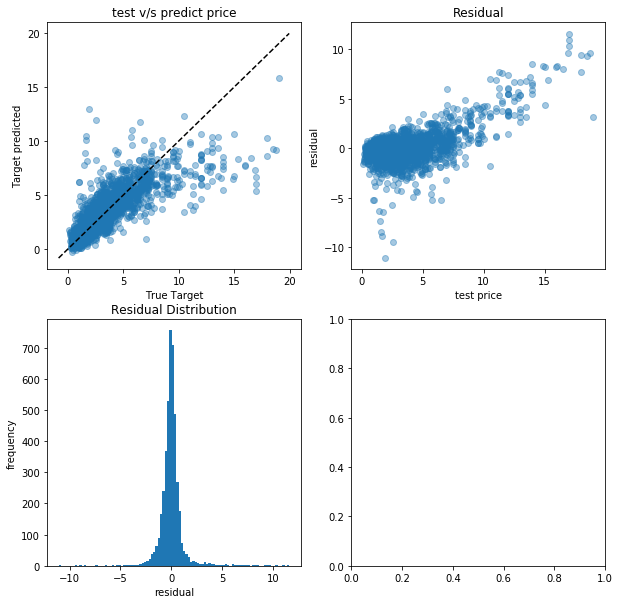

In [18]:
#Ordinary least squares Linear Regression.
model_lr = LinearRegression(fit_intercept=True)
model_lr.fit(X_train_norm, y_train/100000)

pred_y_test_lr = model_lr.predict(X_test_norm)
pred_y_train_lr = model_lr.predict(X_train_norm)
print('Test: ' + get_scores(y_test/100000, pred_y_test_lr))
print('Train: ' + get_scores(y_train/100000, pred_y_train_lr))


f, ax = plot_predict_result(y_test/100000, pred_y_test_lr, figsize=(10,10))


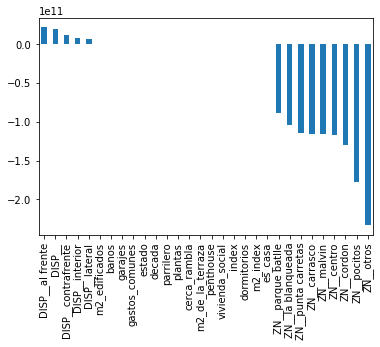

In [19]:
pd.Series(model_lr.coef_, index=X_train.columns).sort_values(ascending=False).plot(kind='bar')

Methods to avoid Over-fitting:
Following are the commonly used methodologies :

Cross-Validation : Cross Validation in its simplest form is a one round validation, where we leave one sample as in-time validation and rest for training the model. But for keeping lower variance a higher fold cross validation is preferred.
Early Stopping : Early stopping rules provide guidance as to how many iterations can be run before the learner begins to over-fit.
Pruning : Pruning is used extensively while building CART models. It simply removes the nodes which add little predictive power for the problem in hand.
Regularization : This is the technique we are going to discuss in more details. Simply put, it introduces a cost term for bringing in more features with the objective function. Hence, it tries to push the coefficients for many variables to zero and hence reduce cost term.
 

### Regularization 
Regularization is a technique we use to prevent models from overfitting.

overfit: The model fits training data too well and It will not be able to generalize on data that it has not seen before.
underfit: The model is too simple and doesn't  fits well to training data.

<img src="https://www.analyticsvidhya.com/wp-content/uploads/2015/02/underfitting-overfitting.png" />

Regularization penalizes overly complex models by adding the norm of the weight vector to the cost function. Since we want to minimize the cost function, we will need to minimize this norm. This causes unrequired components of the weight vector to reduce to zero and prevents the prediction function from being overly complex.

Ridge and Lasso regression are powerful techniques generally used for creating parsimonious models in presence of a ‘large’ number of features. 
- Large enough to enhance the tendency of a model to overfit
- Large enough to cause computational challenges. With modern systems, this situation might arise in case of millions or billions of features     

*" penalizing the magnitude of coefficients of features along with minimizing the error between predicted and actual observations"*

### Ridge Regression
Ridge Regression is a technique used when the data suffers from **multicollinearity** ( independent variables are highly correlated). So Ridge regression solves the multicollinearity problem through shrinkage parameter λ (lambda). It is also known as Linear least squares with l2 regularization. 

Lambda = 0 is a super over-fit scenario and Lambda = Infinity brings down the problem to just single mean estimation.

$$
min(\sum_{i=1}^{N}(y_i-\hat{y_i})^2) = min(\sum_{i=1}^{N}(y_i-\sum_{j=0}^{M}w_j \cdot x_{ij})^2 + \lambda \sum_{j=0}^{M}w_j^2)
$$
$$\parallel y - \mathbf{w}X \parallel _{2}^{2} + \lambda \parallel \mathbf{w} \parallel _{2}^{2}$$

In this equation, we have two components. First one is least square term and other one is lambda of the summation of β2 (beta- square) where β is the coefficient. This is added to least square term in order to **shrink** the parameter to have a **very low variance**.

Important Points:
- The assumptions of this regression is same as least squared regression except normality is not to be assumed
- It shrinks the value of coefficients but doesn’t reaches zero, which suggests no feature selection feature
- This is a regularization method and uses l2 regularization.

Test: RMSE=119405.57, MAE=65710.93, MEAE=37755.07, $R^2$=0.70
Train: RMSE=114841.48, MAE=64798.66, MEAE=38254.71, $R^2$=0.72


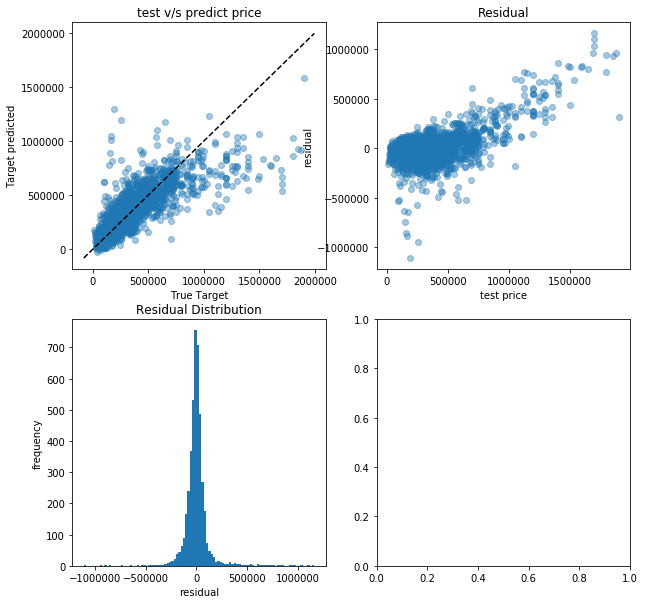

In [20]:
# for alpha in [0.1, 1, 10, 100]:
model_rg = Ridge()
model_rg.fit(X_train_norm, y_train)

pred_y_test_rid = model_rg.predict(X_test_norm)
pred_y_train_rid = model_rg.predict(X_train_norm)
print('Test: ' + get_scores(y_test, pred_y_test_rid))
print('Train: ' + get_scores(y_train, pred_y_train_rid))

f, ax = plot_predict_result(y_test, pred_y_test_rid, figsize=(10, 10))

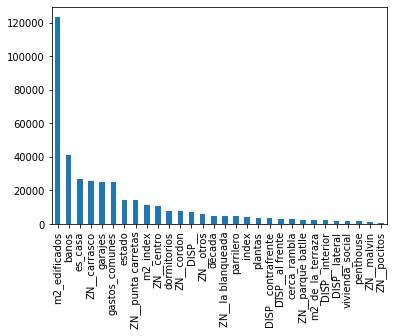

In [21]:
pd.Series(model_rg.coef_, index=X_train.columns).apply(np.abs).sort_values(ascending=False).plot(kind='bar')

Test: RMSE=124054.84, MAE=63201.84, MEAE=30596.99, $R^2$=0.67
Train: RMSE=122850.92, MAE=61977.53, MEAE=30607.43, $R^2$=0.68


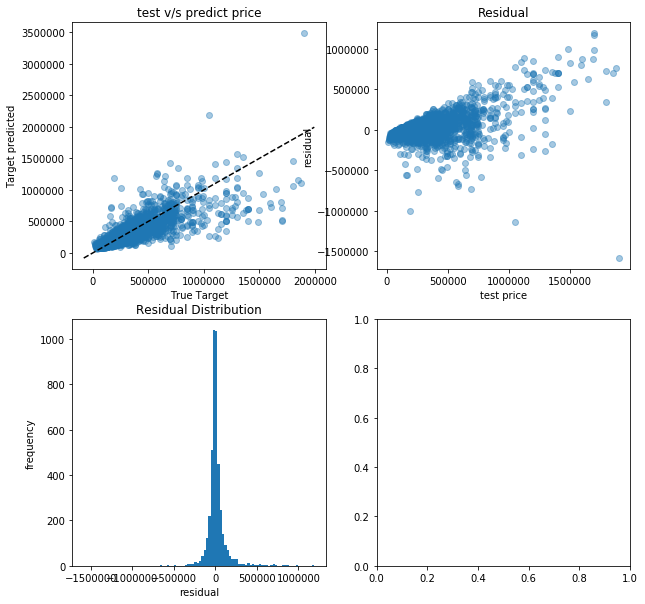

In [22]:
# for alpha in [0.1, 1, 10, 100]:
model_trrg = TransformedTargetRegressor(regressor=Ridge(alpha=1000), func=np.log, inverse_func=np.exp)
model_trrg.fit(X_train_norm, y_train)

pred_y_test_rid_tr = model_trrg.predict(X_test_norm)
pred_y_train_rid_tr = model_trrg.predict(X_train_norm)
print('Test: ' + get_scores(y_test, pred_y_test_rid_tr))
print('Train: ' + get_scores(y_train, pred_y_train_rid_tr))

f, ax = plot_predict_result(y_test, pred_y_test_rid_tr, figsize=(10, 10))

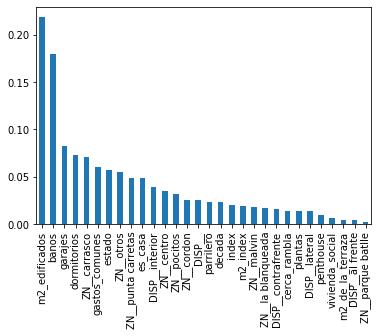

In [23]:
pd.Series(model_trrg.regressor_.coef_, index=X_train.columns).apply(np.abs).sort_values(ascending=False).plot(kind='bar')

### Lasso 
Lasso (Least absolute shrinkage and selection operator) also penalizes the absolute size of the regression coefficients. In addition, it is capable of reducing the variability and improving the accuracy of linear regression models.  Look at the equation below: Lasso regression differs from ridge regression in a way that it uses absolute values in the penalty function, instead of squares. This leads to penalizing (or equivalently constraining the sum of the absolute values of the estimates) values which causes some of the parameter estimates to turn out **exactly zero**. 

$$
\sum_{i=1}^{N}(y_i-\hat{y_i})^2  =\sum_{i=1}^{N}(y_i-\sum_{j=0}^{M}w_j \cdot x_{ij})^2 + \lambda \sum_{j=0}^{M}|w_j|
$$

Important Points:
- The assumptions of this regression is same as least squared regression except normality is not to be assumed
- It shrinks coefficients to zero (exactly zero), which certainly helps in feature selection
- This is a regularization method and uses l1 regularization
- If group of predictors are highly correlated, lasso picks only one of them and shrinks the others to zero

/home/cesar/software/houses-project/venv/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12975449555377.812, tolerance: 81389721997.92577
  positive)


Test: RMSE=119406.14, MAE=65710.79, MEAE=37752.10, $R^2$=0.70
Train: RMSE=114841.48, MAE=64798.58, MEAE=38251.72, $R^2$=0.72


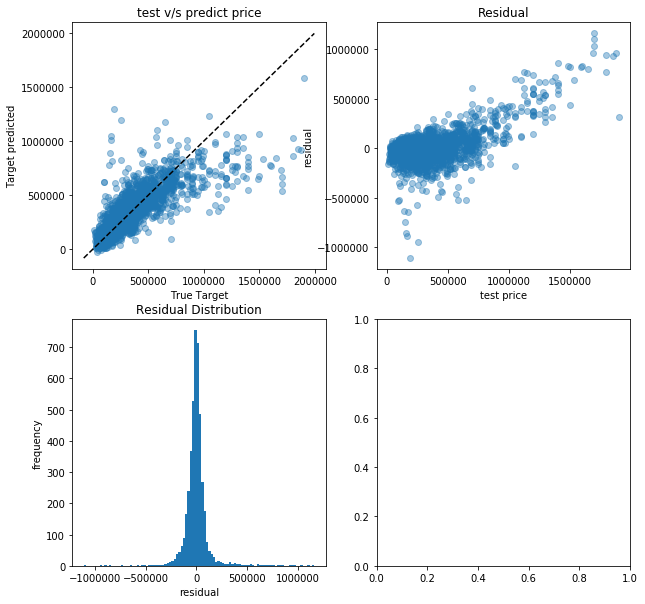

In [24]:
# for alpha in [0.1, 1, 10, 100]:
model_ls = Lasso()
model_ls.fit(X_train_norm, y_train)

pred_y_test_ls = model_ls.predict(X_test_norm)
pred_y_train_ls = model_ls.predict(X_train_norm)
print('Test: ' + get_scores(y_test, pred_y_test_ls))
print('Train: ' + get_scores(y_train, pred_y_train_ls))

f, ax = plot_predict_result(y_test, pred_y_test_ls, figsize=(10, 10))

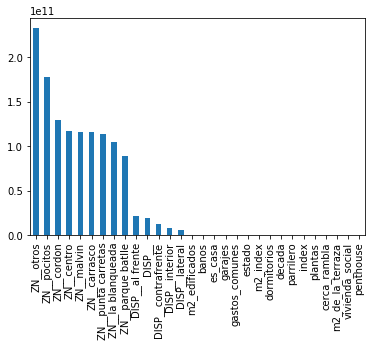

In [25]:
pd.Series(model_lr.coef_, index=X_train.columns).apply(np.abs).sort_values(ascending=False).plot(kind='bar')

### ElasticNetCV
ElasticNet is hybrid of Lasso and Ridge Regression techniques. It is trained with L1 and L2 prior as regularizer. Elastic-net is useful when there are multiple features which are correlated. 

$$
\sum_{i=1}^{N}(y_i-\hat{y_i})^2  =\sum_{i=1}^{N}(y_i-\sum_{j=0}^{M}w_j \cdot x_{ij})^2 + \lambda_{1} \sum_{j=0}^{M}|w_j| + \lambda_{2} \sum_{j=0}^{M}(w_j)^2
$$

Important Points:
- It encourages group effect in case of highly correlated variables
- There are no limitations on the number of selected variables
- It can suffer with double shrinkage

In [26]:
cv_model_ENET = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1],
                        eps=1e-3,
                        n_alphas=100,
                        fit_intercept=True, 
                        normalize=False,
                        precompute='auto',
                        max_iter=2000,
                        tol=0.0001,
                        cv=6, 
                        copy_X=True,
                        verbose=0,
                        n_jobs=-1,
                        positive=False,
                        random_state=0)

cv_model_ENET.fit(X_train_norm, y_train)

print('Optimal alpha: {:.8f}'.format(cv_model_ENET.alpha_))
print('Optimal l1_ratio: {:.3f}'.format(cv_model_ENET.l1_ratio_))
print('Number of iterations {:d}'.format(cv_model_ENET.n_iter_))

pred_y_test_ENet = cv_model_ENET.predict(X_test_norm)
pred_y_train_ENet = cv_model_ENET.predict(X_train_norm)

print('Test: ' + get_scores(y_test, pred_y_test_ENet))
print('Train: ' + get_scores(y_train, pred_y_train_ENet))

Optimal alpha: 226.00538255
Optimal l1_ratio: 1.000
Number of iterations 53
Test: RMSE=119392.52, MAE=65555.96, MEAE=37574.66, $R^2$=0.70
Train: RMSE=114846.89, MAE=64650.26, MEAE=37908.91, $R^2$=0.72


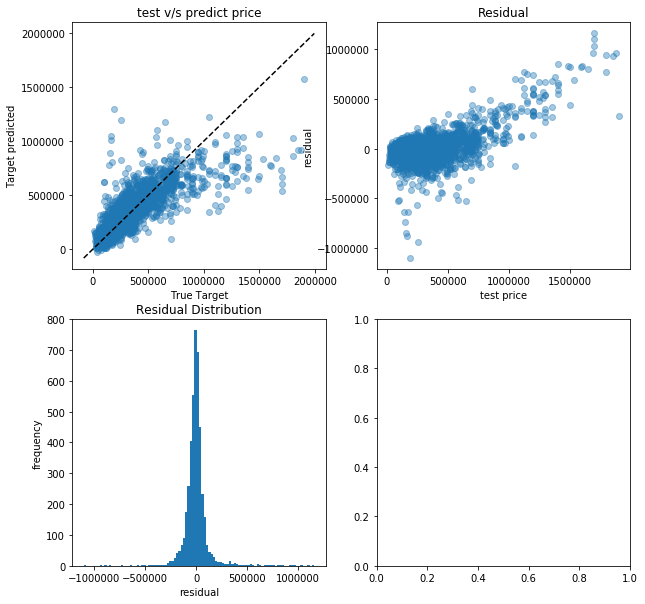

In [27]:
plot_predict_result(y_test, pred_y_test_ENet);

28 features, reduction of 6.67%


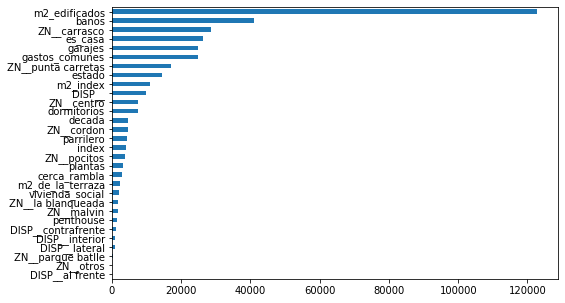

In [28]:
feature_importance = pd.Series(np.abs(cv_model_ENET.coef_), index=X_train.columns)

n_selected_features = (feature_importance>0).sum()
print('{0:d} features, reduction of {1:2.2f}%'.format(
    n_selected_features,(1-n_selected_features/len(feature_importance))*100))

f, ax = plt.subplots(figsize = (8, 5))
feature_importance.sort_values().tail(30).plot(kind='barh', ax=ax);

In [29]:
sub_col = feature_importance.sort_values().tail(20).sort_values(ascending=False).index
sub_col

Index(['m2_edificados', 'banos', 'ZN__carrasco', 'es_casa', 'garajes',
       'gastos_comunes', 'ZN__punta carretas', 'estado', 'm2_index', 'DISP__',
       'ZN__centro', 'dormitorios', 'decada', 'ZN__cordon', 'parrilero',
       'index', 'ZN__pocitos', 'plantas', 'cerca_rambla', 'm2_de_la_terraza'],
      dtype='object')

### Other methods

- Robust regression
- Bayesian linear regression

In [30]:
from sklearn.neighbors import KNeighborsRegressor

Test: RMSE=152653.99, MAE=84546.49, MEAE=46250.00, $R^2$=0.51
Train: RMSE=129930.42, MAE=73554.61, MEAE=40750.00, $R^2$=0.64


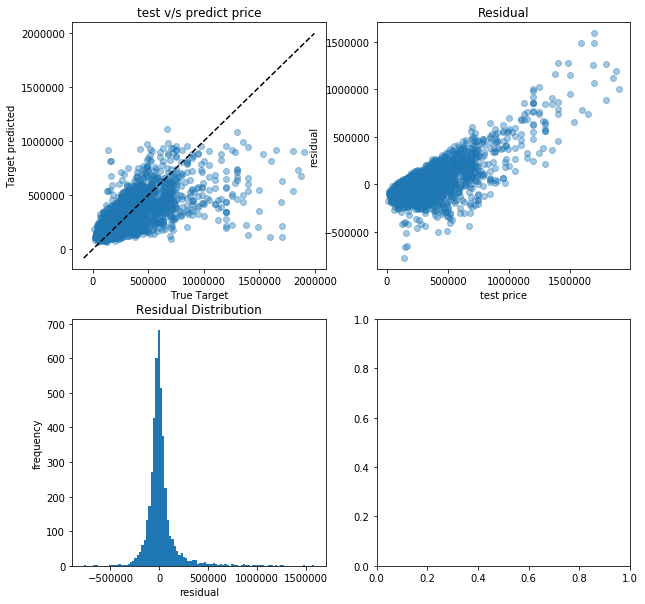

In [31]:
model_knr = KNeighborsRegressor(n_neighbors=8)
model_knr.fit(X_train, y_train)

pred_y_test_knr = model_knr.predict(X_test)
pred_y_train_knr = model_knr.predict(X_train)

print('Test: ' + get_scores(y_test, pred_y_test_knr))
print('Train: ' + get_scores(y_train, pred_y_train_knr))

f, ax = plot_predict_result(y_test, pred_y_test_knr, figsize=(10, 10))

## No-linear Models
### Decision Trees
Decision trees are used in everyday life decisions, not just in machine learning. 
It can be defined as a stream of logical rules of the form "feature A value is less than x and feature b value is less than y, so the result is the value Z". The advantage of this algorithm is that they are easily interpretable. 

A desition tree has two principal elements, nodes and leafs. The algorith start with a root node with all observations and then split it in 2 nodes (left and right) with a subset of the original obsevation. The last node in a tree are the leaf. In a regresion task, a common criterio for split a node is **variance** and the predicted values is the **average of a leaf**.

<img src="https://scikit-learn.org/stable/_images/sphx_glr_plot_tree_regression_001.png" />

In [70]:
model_tree = DecisionTreeRegressor(max_depth=16,
                                   random_state=0,)
model_tree.fit(X_train, y_train)

pred_y_test_tree = model_tree.predict(X_test)
pred_y_train_tree = model_tree.predict(X_train)

print('Test: ' + get_scores(y_test, pred_y_test_tree))
print('Train: ' + get_scores(y_train, pred_y_train_tree))


Test: RMSE=127964.31, MAE=60484.37, MEAE=27260.26, $R^2$=0.65
Train: RMSE=33950.84, MAE=18432.84, MEAE=8066.67, $R^2$=0.98


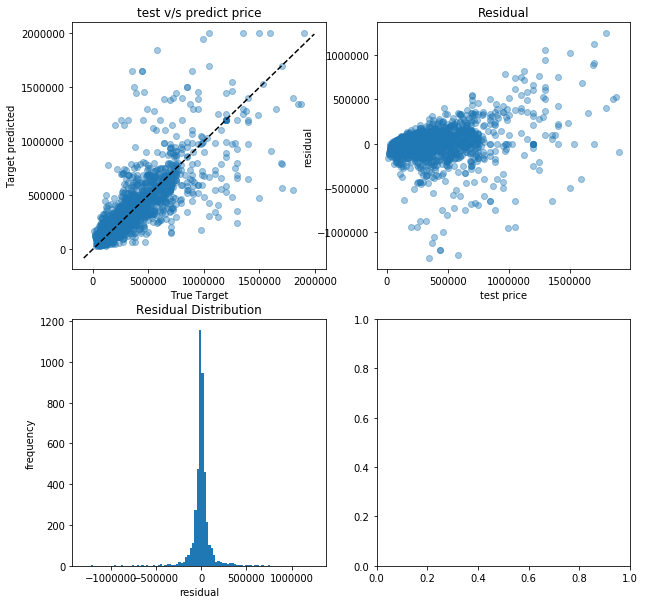

In [71]:
plot_predict_result(y_test, pred_y_test_tree);

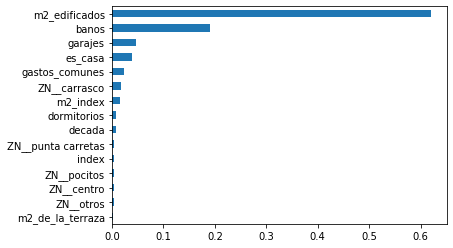

In [34]:
f, ax = plt.subplots()
(pd
 .Series(model_tree.feature_importances_, index=X_test.columns)
 .sort_values()[-15:]
 .plot(ax=ax, kind='barh')
)

## Ensamble Methods
Ensambles algorithems instead of create a one super-accurate model create several low-accurate or weak models end them combine the predictions of each models in a one high-accurate meta-model. 

### Bagging method - Random Forest
Random Forest is a **Bagging method** or ensamble method is a technique that create collection of Decision trees with a subset of samples and features with permutations (sampling with replacement).  One important thing in Random Forest is that it **reduces variance without changing the bias** of the complete ensemble. 


In the Random Forest model, the original training data is randomly sampled-with-replacement generating small subsets of data (see the image below). These subsets are also known as bootstrap samples. These bootstrap samples are then fed as training data to many Desition Trees of large depths. Each of these DTs is trained separately on these bootstrap samples. This aggregation of DTs is called the Random Forest ensemble. The concluding result of the ensemble model is determined by counting a majority vote from all the DTs. This concept is known as **Bagging or Bootstrap Aggregation**.
 
 The predicted value for a regresion problem is 
 $$
 y = \hat{f}(x) = \frac{1}{B}\sum_{b=1}^{B}f_b(x)
 $$
 where $f_{b}(x)$ is the result of a weak model 

In [35]:
model_rfr = RandomForestRegressor(n_estimators=100, oob_score=True)
model_rfr.fit(X_train, y_train)
pred_y_test_rf = model_rfr.predict(X_test, )
pred_y_train_rf = model_rfr.predict(X_train, )

print(get_scores(y_test, pred_y_test_rf))
print(get_scores(y_train, pred_y_train_rf))



RMSE=92994.73, MAE=48029.70, MEAE=23163.74, $R^2$=0.82
RMSE=34230.78, MAE=17544.44, MEAE=8432.00, $R^2$=0.97


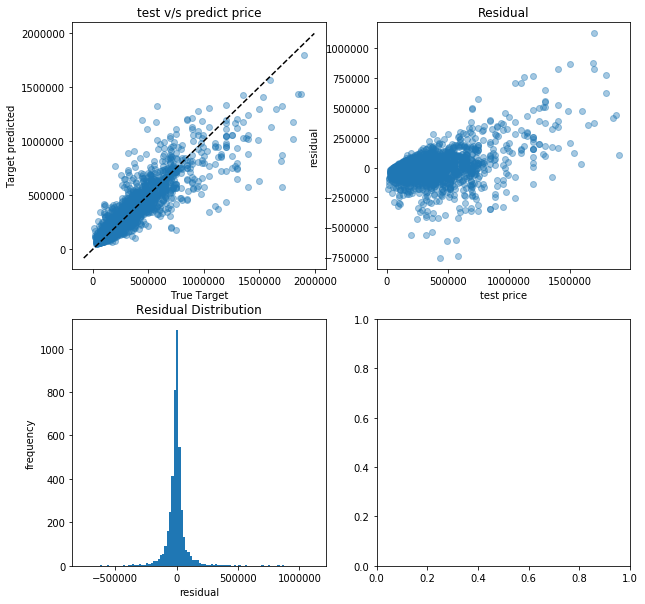

In [36]:
plot_predict_result(y_test, pred_y_test_rf);


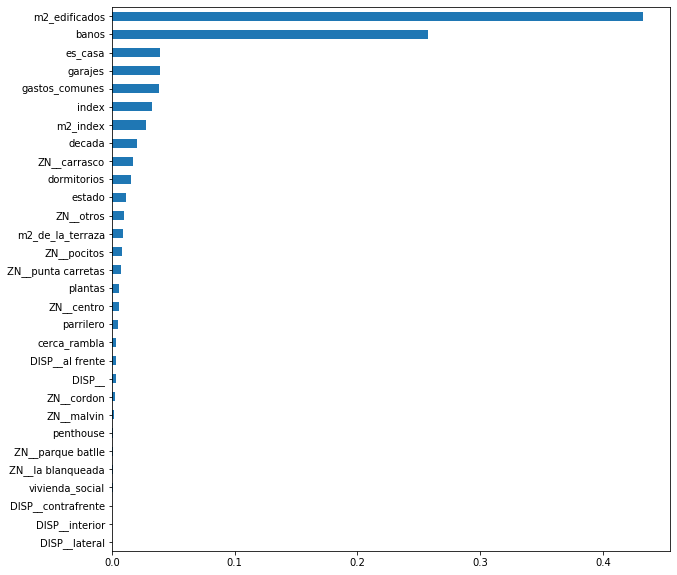

In [37]:
f, ax = plt.subplots(figsize=(10, 10))
pd.Series(model_rfr.feature_importances_, index=X_train.columns).sort_values(ascending=True).plot(kind='barh')

### Boosting methods - XGboost
Boosting methods consists in using original dataset and train iteratively a multiple models by using weak models. Each of this weak models try to "fix" the errors whis the previous models make. The final model is a ensamble of sequence of models.  In contrast to Bagging methods, boosting methods **reduces bais instead of variance** of the complete ensemble. To avoid overfitting we should keep atention to tunning te deph and the number of the trees.

XGboost is a particular implementation of  Boosting called Gradient Boosting using Desiotion Trees as weak learners.

In [38]:
from xgboost import XGBRegressor, plot_importance 

In [39]:
model_xgb = XGBRegressor(max_depth=3)
model_xgb.fit(X_train, y_train, verbose=False)

pred_y_test_xgb = model_xgb.predict(X_test)
pred_y_train_xgb = model_xgb.predict(X_train)

print('Test: ' + get_scores(y_test, pred_y_test_xgb))
print('Train: ' + get_scores(y_train, pred_y_train_xgb))


/home/cesar/software/houses-project/venv/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:40:01] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Test: RMSE=99838.65, MAE=55191.58, MEAE=29002.67, $R^2$=0.79
Train: RMSE=91961.56, MAE=51904.81, MEAE=28529.17, $R^2$=0.82


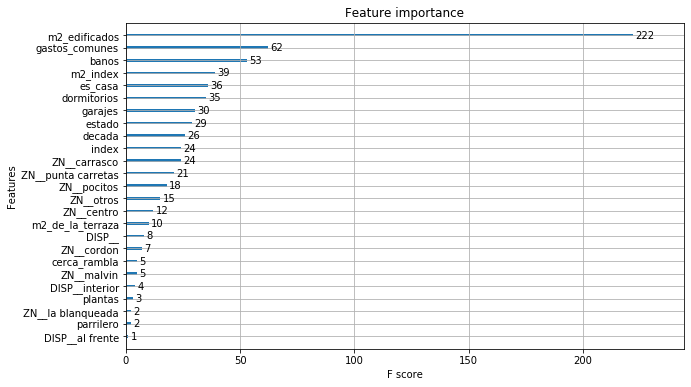

In [40]:
f, ax = plt.subplots(figsize=(10, 6))
plot_importance(model_xgb, ax=ax)


### Boosting methods - LightGBM

In [41]:
import lightgbm

In [42]:
model_lgbr = lightgbm.LGBMRegressor(max_depth=5, learning_rate=0.01, n_estimators=1000)
model_lgbr.fit(X_train, y_train, verbose=False)

pred_y_test_lgbr = model_lgbr.predict(X_test)
pred_y_train_lgbr = model_lgbr.predict(X_train)

print('Test: ' + get_scores(y_test, pred_y_test_lgbr))
print('Train: ' + get_scores(y_train, pred_y_train_lgbr))


Test: RMSE=93894.10, MAE=50774.08, MEAE=26409.60, $R^2$=0.81
Train: RMSE=79946.37, MAE=45421.70, MEAE=24697.72, $R^2$=0.86


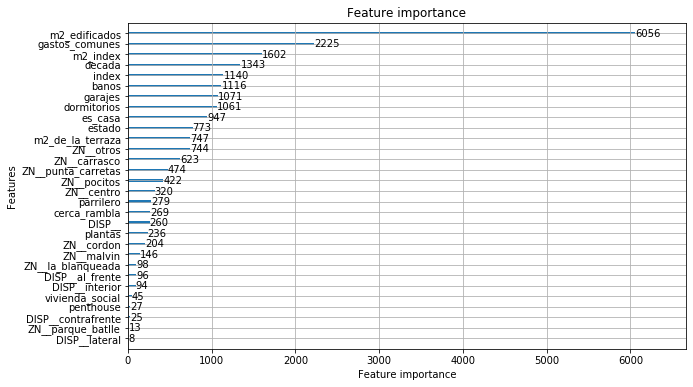

In [43]:
f, ax = plt.subplots(figsize=(10, 6))
lightgbm.plot_importance(model_lgbr, ax=ax)


### CatBoost

In [44]:
from catboost import CatBoostRegressor, Pool

In [45]:
model=CatBoostRegressor(iterations=100,
                        depth=11,
                        learning_rate=0.1,
                        loss_function='RMSE')
model.fit(X_train,
          y_train,
#           cat_features=categorical_features_indices,
#           eval_set=(X_test, y_test),
#           plot=True,
          verbose=False
         )

# make the prediction using the resulting model
preds = model.predict(X_test)
print('Test: ' + get_scores(y_test, preds))

Test: RMSE=94378.75, MAE=50534.18, MEAE=26585.61, $R^2$=0.81


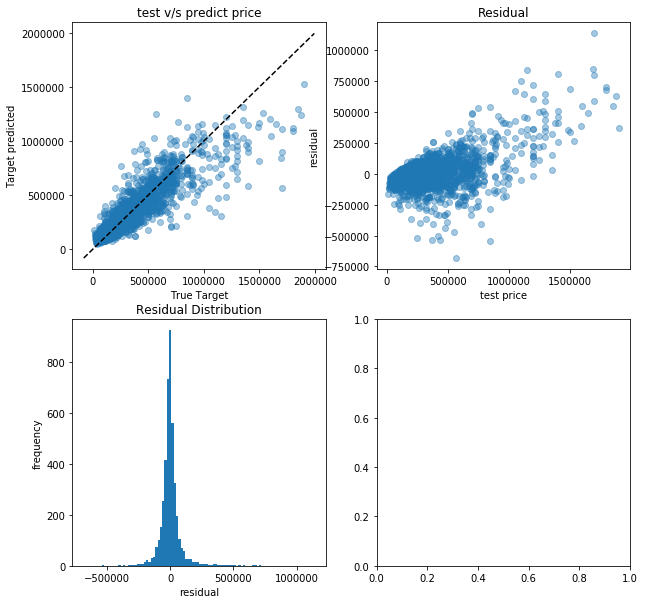

In [46]:
plot_predict_result(y_test.to_numpy(), preds);

# Pipelines

In [47]:
from sklearn.pipeline import Pipeline


Test: RMSE=119406.15, MAE=65712.89, MEAE=37768.34, $R^2$=0.70
Train: RMSE=114841.48, MAE=64800.31, MEAE=38263.62, $R^2$=0.72


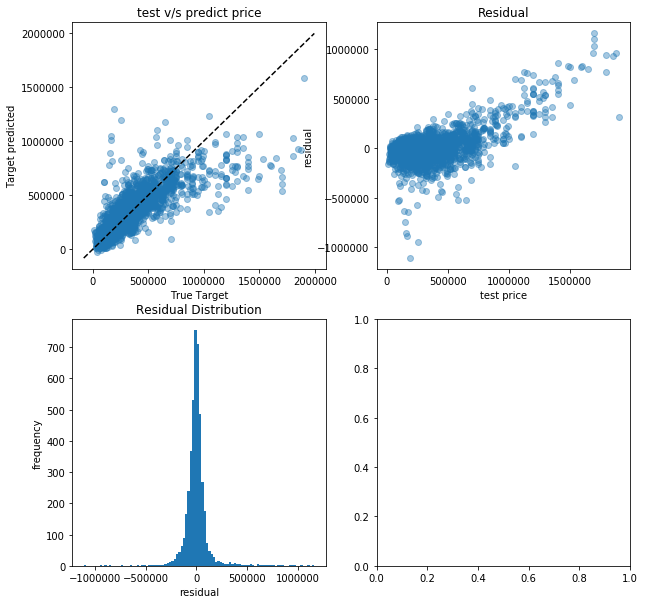

In [48]:
pipe_lr = Pipeline(steps=[
    ('scaler', StandardScaler()),
#     ('pca', PCA(n_components=0.8)),
    ('lineal_regresor', LinearRegression(fit_intercept=True))
    
])
pipe_lr.fit(X_train, y_train)

pred_y_test_pp_lr = pipe_lr.predict(X_test)
pred_y_train_pp_lr = pipe_lr.predict(X_train)
print('Test: ' + get_scores(y_test, pred_y_test_pp_lr))
print('Train: ' + get_scores(y_train, pred_y_train_pp_lr))


f, ax = plot_predict_result(y_test, pred_y_test_pp_lr)

## Random Forest

Test: RMSE=113053.47, MAE=58441.32, MEAE=27950.57, $R^2$=0.73
Train: RMSE=50072.34, MAE=22491.86, MEAE=9988.90, $R^2$=0.95


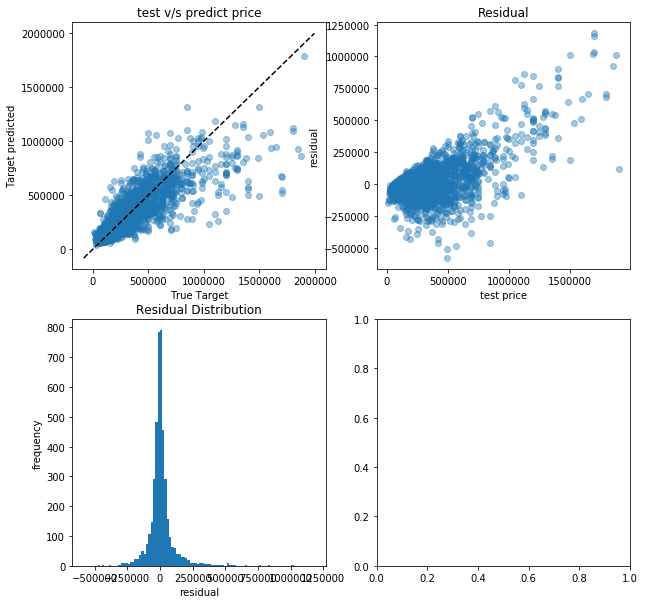

In [49]:
pipe_rf = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=0.8)),
    ('random_forest', RandomForestRegressor(n_estimators=100,
                                            criterion='mse',
                                            n_jobs=-1))
    
])
pipe_targ_rf = TransformedTargetRegressor(
    regressor=pipe_rf,
    func=np.log,
    inverse_func=np.exp)

pipe_targ_rf.fit(X_train, y_train)
pred_test_price_rf = pipe_targ_rf.predict(X_test)
pred_train_price_rf = pipe_targ_rf.predict(X_train)
print('Test: ' + get_scores(y_test, pred_test_price_rf))
print('Train: ' + get_scores(y_train, pred_train_price_rf))


f, ax = plot_predict_result(y_test, pred_test_price_rf)

## Hiperparameters tunning

In [50]:
rfr = RandomForestRegressor(random_state=42,)

# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rfr.get_params())

Parameters currently in use:

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 'warn',
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


## GridSearch
GridSearchCV

In [51]:
# specify parameters and distributions to sample from
param_grid = {
#     'bootstrap': [True, False],
#      'max_depth': [10, 50, None],
#      'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2,],
     'min_samples_split': [2, 5,],
     'n_estimators': [200, 400,]
}

# Instantiate the grid search model
grid_search = GridSearchCV(
    estimator=rfr,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2,
)
# Fit the random search model
grid_search.fit(X_train, y_train);

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  24 | elapsed:  1.6min remaining:    8.9s
[Parallel(n_jobs=-1)]: Done  24 out of  24 | elapsed:  1.8min finished


In [52]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=400,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [53]:
grid_search.cv_results_

{'mean_fit_time': array([22.65090664, 46.73756711, 20.00705298, 41.08183066, 19.81172434,
        38.758641  , 19.4573462 , 28.15056356]),
 'std_fit_time': array([0.27498499, 0.4287586 , 0.29083244, 0.37160873, 0.08407614,
        0.25114108, 0.08669033, 3.85626286]),
 'mean_score_time': array([0.43646185, 0.88856665, 0.3733484 , 0.74184195, 0.37510506,
        0.58685923, 0.33771928, 0.39293106]),
 'std_score_time': array([0.00379015, 0.00368265, 0.00323121, 0.00088573, 0.00238848,
        0.08248187, 0.03036644, 0.03747641]),
 'param_min_samples_leaf': masked_array(data=[1, 1, 1, 1, 2, 2, 2, 2],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[2, 2, 5, 5, 2, 2, 5, 5],
              mask=[False, False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[200, 400, 200, 400, 200

## RandomSearch


In [54]:
random_grid = {
    'bootstrap': [True, False],
    'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
    'max_features': ['auto', 'sqrt'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [2, 5, 10],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
}
random_search_rfr = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42,),
    param_distributions=random_grid,
#     n_iter = 100,
    cv = 3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    return_train_score=True,
)

# Fit the random search model
random_search_rfr.fit(X_train, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/cesar/software/houses-project/venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/cesar/software/houses-project/venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/cesar/software/houses-project/venv/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
/home/

In [56]:
random_search_rfr.best_params_

{'n_estimators': 2000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 50,
 'bootstrap': True}

In [57]:
random_search_rfr.best_score_

0.8118561244308038

In [58]:
random_search_rfr.cv_results_


{'mean_fit_time': array([  3.82452377,  16.65548325,  93.57836835,  35.17381612,
        149.81519008,  13.62632664, 304.95269871,   2.87723907,
        102.7682902 , 192.9515148 ]),
 'std_fit_time': array([ 0.0251924 ,  0.06471431,  1.40183913,  0.46367229,  2.6757478 ,
         0.21114816, 14.75959077,  0.14453308,  1.19168885,  5.51472422]),
 'mean_score_time': array([0.29627554, 0.88614599, 1.22142855, 2.68524901, 1.86194007,
        0.77903136, 3.26295718, 0.18333507, 1.8181181 , 3.02152673]),
 'std_score_time': array([0.00711605, 0.01748692, 0.03460576, 0.06388329, 0.02899779,
        0.04247822, 0.80476441, 0.00630059, 0.02762539, 0.55886832]),
 'param_n_estimators': masked_array(data=[200, 600, 600, 1400, 1000, 400, 2000, 200, 1200, 2000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_min_samples_split': masked_array(data=[10, 10, 2, 5, 10, 10, 2, 5, 2, 5

In [63]:


best_model = RandomForestRegressor(**random_search_rfr.best_params_, n_jobs=-1,)
best_model.fit(X_train[sub_col], y_train);

In [64]:
pred_y_test_bm = best_model.predict(X_test[sub_col])
pred_y_train_bm = best_model.predict(X_train[sub_col])
print('Test: ' + get_scores(y_test, pred_y_test_bm))
print('Train: ' + get_scores(y_train, pred_y_train_bm))

Test: RMSE=93603.03, MAE=49312.14, MEAE=24053.48, $R^2$=0.81
Train: RMSE=48212.27, MAE=24183.44, MEAE=11620.00, $R^2$=0.95


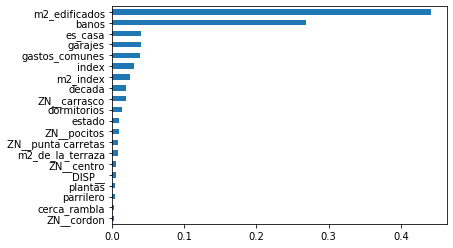

In [67]:
pd.Series(best_model.feature_importances_, index=X_train[sub_col].columns).sort_values().plot(kind='barh')